# feature extraction for logistic CVD models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading ADNI flair mask t1 dataset

In [3]:
# ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

In [4]:
# IDs = ADNI_ds.getIDs()

In [5]:
# len(IDs)

### Loading ADNI predictions

In [6]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [7]:

model_name = "CHAL_based_SSN_Ensemble"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:26<00:00,  2.90it/s]


In [8]:

model_name_for_pred = "CHAL_based_SSN_Ensemble_Mean"
output_maps_dir_for_pred = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name_for_pred}/"
output_maps_for_pred, key_order_for_pred = load_output_maps(output_maps_dir_for_pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:25<00:00,  2.91it/s]


In [9]:
key_order

['ent', 'pred', 'seg', 'var']

In [10]:
ID = list(output_maps_for_umaps.keys())[2]

In [11]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

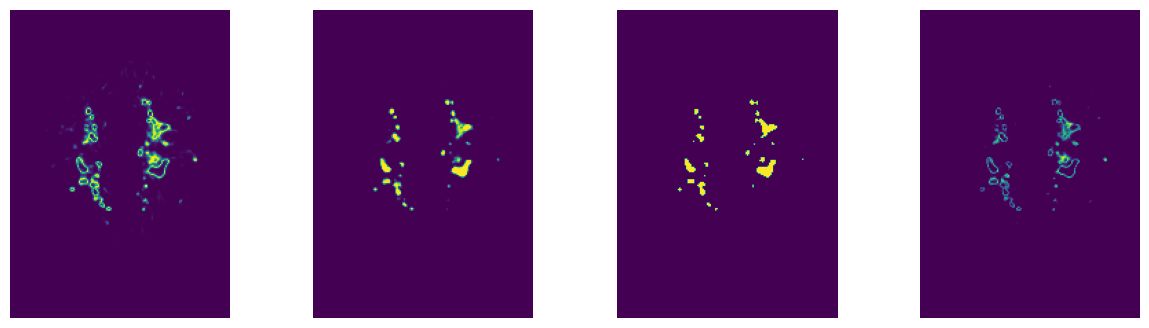

In [12]:
plt.figure(figsize=(15,4))
islice = 31
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img_us[i][islice])
    plt.axis('off')

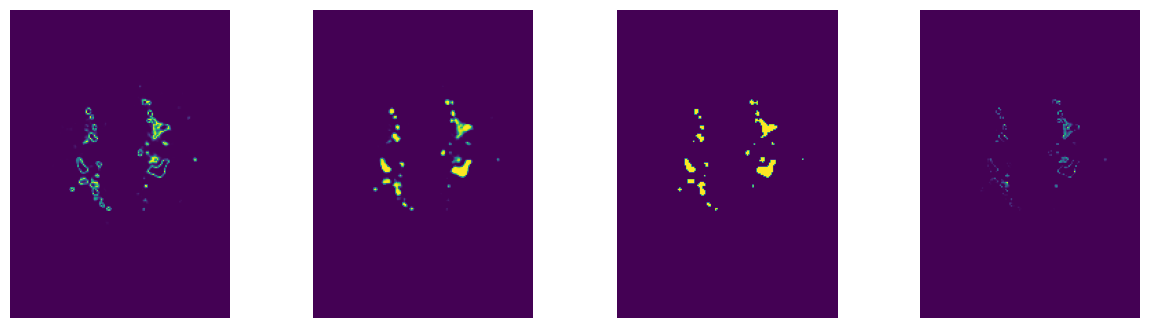

In [13]:
ent, pred, seg, var = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [14]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
var_voxels = var[var > t/10]

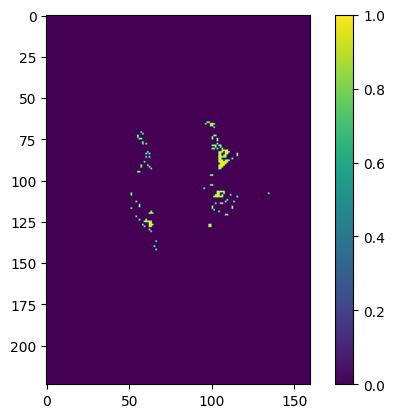

In [15]:
plt.imshow(var[islice]>0.01)
plt.colorbar()

<AxesSubplot: ylabel='Density'>

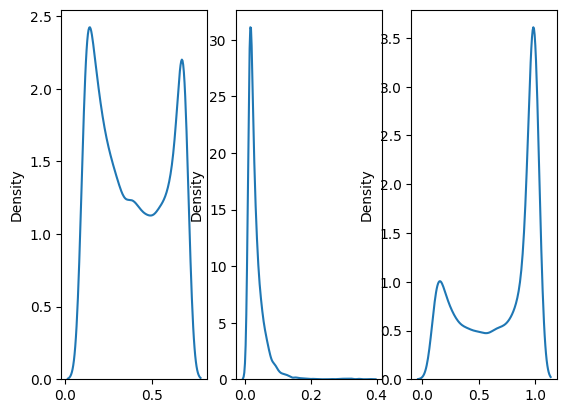

In [16]:
plt.subplot(1,3,1)
sns.kdeplot(ent_voxels)
plt.subplot(1,3,2)
sns.kdeplot(var_voxels)
plt.subplot(1,3,3)
sns.kdeplot(pred_voxels)

In [17]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [18]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [19]:
histogram_distribution(ent_voxels, 20)

tensor([0.0965, 0.0745, 0.0646, 0.0552, 0.0494, 0.0446, 0.0426, 0.0373, 0.0348,
        0.0385, 0.0357, 0.0340, 0.0340, 0.0323, 0.0347, 0.0352, 0.0391, 0.0419,
        0.0537, 0.1213])

In [20]:
# counts, counts.sum()

<AxesSubplot: ylabel='Count'>

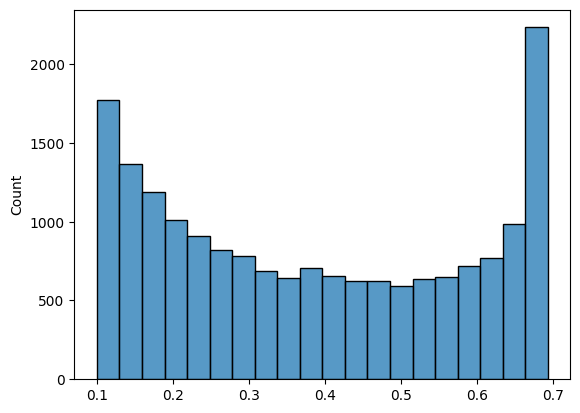

In [21]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [22]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [23]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [24]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((224, 160))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [25]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [26]:
IDs_outmaps[0:5], IDs[0:5]

(['CVD001_out_maps',
  'CVD002_out_maps',
  'CVD003_out_maps',
  'CVD004_out_maps',
  'CVD008_out_maps'],
 [('CVD001', 'CVD001_out_maps'),
  ('CVD002', 'CVD002_out_maps'),
  ('CVD003', 'CVD003_out_maps'),
  ('CVD004', 'CVD004_out_maps'),
  ('CVD008', 'CVD008_out_maps')])

In [27]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([48, 224, 160])

In [28]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:31<00:00,  7.90it/s]


In [29]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([48, 224, 160]), tensor(29))

torch.Size([56, 224, 160])
torch.Size([56, 224, 160])


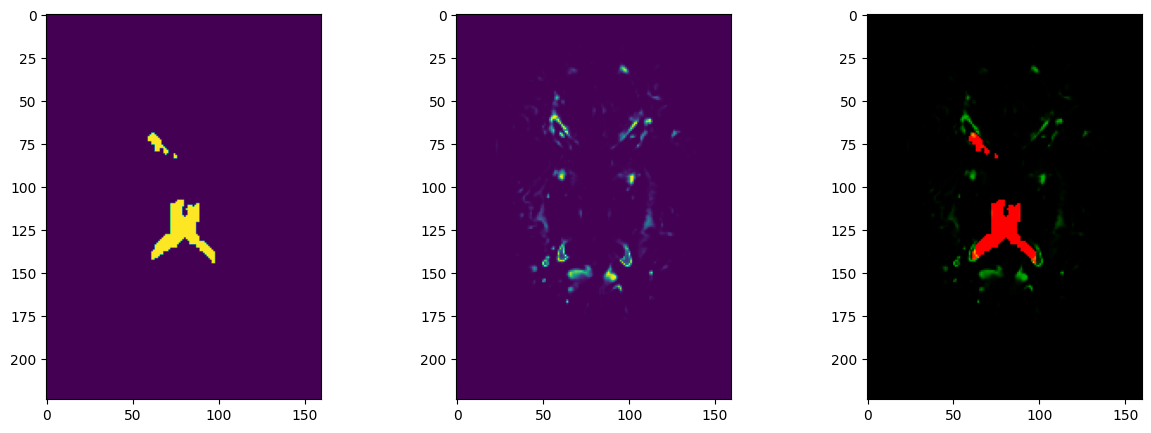

In [30]:
islice = 32
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[scan_id].shape[1:], 3)
print(output_maps_for_umaps[IDs[scan_id][1]][0].shape)
print(vent_maps[scan_id].shape)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [31]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [32]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [33]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [34]:
import cc3d

In [35]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [36]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [37]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [38]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [39]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [40]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [41]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [42]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [43]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [44]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [45]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [46]:
# joint_counts.shape

In [47]:
# plt.imshow(joint_counts); plt.colorbar()

In [48]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [49]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [50]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [51]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [52]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [53]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [54]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [55]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "var", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            elif input_type == "var":
                umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
                ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
                maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
        

  0%|                                                                                                                                                                 | 0/250 [00:00<?, ?it/s]

CVD001


/tmp/ipykernel_3638774/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_3638774/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


254 254


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)


87 87
10 10
1 1
0 0
0 0
183 183
76 76
18 18
5 5
0 0
0 0
0 0
0 0
0 0


  0%|▌                                                                                                                                                        | 1/250 [00:03<14:10,  3.41s/it]

0 0
0 0
0 0
CVD002
473 461
372 354
231 193
241 159
251 134
272 122
394 370
364 310
366 253
330 174
276 141
121 72
38 17
39 16
36 10


  1%|█▏                                                                                                                                                       | 2/250 [00:14<33:15,  8.05s/it]

31 4
29 0
28 0
CVD003
399 380
247 207
247 151
401 153
587 199
833 285
344 277
447 217
798 324
841 337
504 244
166 94
51 24
42 12
44 12
40 5
43 0


  1%|█▊                                                                                                                                                       | 3/250 [00:30<48:24, 11.76s/it]

36 0
CVD004
694 674
409 382
246 202
202 155
175 122
157 99
555 528
373 332
268 217
202 143
179 122
116 77
69 32
65 20
55 8
55 6
52 0


  2%|██▍                                                                                                                                                      | 4/250 [00:41<46:23, 11.32s/it]

46 0
CVD008
463 432
329 284
248 154
458 210
635 260
864 330
410 364
442 304
930 472
957 464
502 235
191 105
113 44
114 36
102 20
101 12
98 0


  2%|███                                                                                                                                                      | 5/250 [01:01<58:36, 14.35s/it]

98 0
CVD009
810 792
628 592
530 469
480 348
463 277
552 289
740 698
690 572
768 497
679 415
383 227
185 96
125 82
86 38
75 25
67 12


  2%|███▌                                                                                                                                                   | 6/250 [01:21<1:05:52, 16.20s/it]

62 0
53 0
CVD011
493 466
316 283
221 178
193 131
189 119
176 99
418 384
300 248
228 162
193 120
152 96
88 49
63 27
59 19
57 13
52 7
48 0


  3%|████▎                                                                                                                                                    | 7/250 [01:30<56:22, 13.92s/it]

45 0
CVD012
491 489
332 325
174 158
150 101
158 98
208 113
377 372
287 267
270 216
258 144
219 116
84 48
59 41
48 28
38 17


  3%|████▉                                                                                                                                                    | 8/250 [01:39<49:35, 12.29s/it]

31 9
29 0
28 0
CVD013
335 330
277 265
212 174
181 113
192 108
195 99
332 316
291 257
251 190
205 124
180 103
91 55
39 21
38 19
33 13


  4%|█████▌                                                                                                                                                   | 9/250 [01:47<43:59, 10.95s/it]

28 5
25 0
26 0
CVD014
521 502
361 339
296 264
246 199
250 184
264 169
414 391
347 312
319 248
366 217
364 201
213 130
104 65
82 34
77 24
72 11
74 0


  4%|██████                                                                                                                                                  | 10/250 [01:58<44:58, 11.24s/it]

71 0
CVD016
650 610
440 381
406 287
562 278
774 315
1053 374
585 493
775 488
1223 580
1086 541
436 196
128 68
125 53
115 36
101 19
104 13
97 0


  4%|██████▋                                                                                                                                                 | 11/250 [02:22<59:16, 14.88s/it]

89 0
CVD017
356 342
216 197
148 123
110 81
110 74
92 51
268 248
205 181
149 118
122 81
104 70
69 45
53 28
43 17
43 14
35 4
33 0


  5%|███████▎                                                                                                                                                | 12/250 [02:28<48:27, 12.22s/it]

32 0
CVD018
145 145
87 87
39 39
14 14
14 14
1 1
123 123
68 68
34 34
20 20
16 16


  5%|███████▉                                                                                                                                                | 13/250 [02:30<35:53,  9.09s/it]

18 18
0 0
0 0
0 0
0 0
0 0
0 0
CVD019
397 378
293 270
185 154
174 135
156 109
141 86
365 340
284 257
233 185
176 125
145 95
89 49
62 35
47 19
48 15
44 7
39 0


  6%|████████▌                                                                                                                                               | 14/250 [02:38<34:25,  8.75s/it]

34 0
CVD020
484 456
363 324
237 178
300 172
351 167
482 191
423 378
405 319
486 273
563 287
335 158
178 104
100 36
110 38
100 25
94 11
89 0


  6%|█████████                                                                                                                                               | 15/250 [02:52<40:26, 10.33s/it]

83 0
CVD021
510 454
412 339
392 289
421 271
448 253
491 261
471 392
464 347
521 329
516 304
400 230
197 119
152 65
128 33
122 22
113 10
114 0


  6%|█████████▋                                                                                                                                              | 16/250 [03:08<46:54, 12.03s/it]

111 0
CVD023
769 741
507 458
390 305
451 267
518 252
610 252
555 504
517 392
689 376
676 354
292 181
107 52
136 81
102 44
90 27
84 14
73 0


  7%|██████████▎                                                                                                                                             | 17/250 [03:25<53:11, 13.70s/it]

73 0
CVD024
637 615
381 356
314 275
232 172
213 125
214 108
508 483
381 333
328 246
268 173
228 144
154 95
72 41
60 25
55 13
51 6


  7%|██████████▉                                                                                                                                             | 18/250 [03:37<51:19, 13.28s/it]

48 0
41 0
CVD025
259 235
201 174
233 147
490 198
746 243
1094 328
267 196
686 311
1185 479
786 360
342 164
127 65
56 30
55 28
52 22
45 13
37 0


  8%|███████████▌                                                                                                                                            | 19/250 [03:56<56:47, 14.75s/it]

39 0
CVD028
350 331
248 205
286 174
547 200
826 272
1252 427
358 286
672 319
1225 496
1266 637
601 280
185 84
84 35
78 23
76 18
75 9
71 0
66 0


  8%|████████████                                                                                                                                          | 20/250 [04:17<1:04:45, 16.89s/it]

CVD030
444 417
265 233
179 141
121 81
109 65
103 61
351 319
242 206
158 119
117 74
90 52
61 31
48 16
42 10
38 6
37 3


  8%|████████████▊                                                                                                                                           | 21/250 [04:24<52:57, 13.88s/it]

34 0
33 0
CVD031
619 593
413 376
284 225
311 187
379 190
533 247
525 482
452 351
547 316
770 400
542 286
193 108
109 50
124 50
115 33
111 16
100 0


  9%|█████████████▍                                                                                                                                          | 22/250 [04:43<58:09, 15.30s/it]

101 0
CVD032
372 349
276 238
233 156
251 145
272 140
301 140
347 309
311 239
328 197
265 138
176 90
76 39
65 32
49 13
45 7
46 6


  9%|█████████████▉                                                                                                                                          | 23/250 [04:54<52:38, 13.91s/it]

43 0
43 0
CVD033
456 427
320 274
314 221
450 231
516 227
633 266
406 350
487 325
647 338
643 340
402 227
146 80
77 26
73 20
65 9
64 4
62 0


 10%|██████████████▌                                                                                                                                         | 24/250 [05:11<56:21, 14.96s/it]

63 0
CVD034
488 472
313 280
285 220
340 202
379 194
457 214
411 365
398 295
488 279
484 264
282 188
129 88
84 42
79 34
78 24
71 12
64 0


 10%|███████████████▏                                                                                                                                        | 25/250 [05:24<54:03, 14.41s/it]

65 0
CVD035
454 438
276 256
196 172
180 142
175 127
163 110
339 320
269 243
220 184
212 164
182 132
120 91
65 37
52 17
51 15
46 9


 10%|███████████████▊                                                                                                                                        | 26/250 [05:33<47:44, 12.79s/it]

40 0
33 0
CVD036
464 435
290 248
324 211
569 222
809 272
1134 378
363 301
610 299
1331 551
829 388
345 153
126 61
105 44
95 31
82 16
80 13
68 0


 11%|████████████████▍                                                                                                                                       | 27/250 [05:56<58:50, 15.83s/it]

73 0
CVD037
105 105
28 28
9 9
5 5
0 0
0 0
62 62
22 22
7 7
6 6


 11%|█████████████████                                                                                                                                       | 28/250 [05:57<42:19, 11.44s/it]

3 3
2 2
0 0
0 0
0 0
0 0
0 0
0 0
CVD038
459 432
311 276
241 192
281 189
304 178
356 186
384 349
316 260
369 226
393 237
302 197
141 90
102 62
94 50
75 26
62 9
58 0


 12%|█████████████████▋                                                                                                                                      | 29/250 [06:10<43:08, 11.71s/it]

52 0
CVD039
506 470
354 297
323 196
502 253
608 280
706 308
436 376
489 326
668 329
642 272
334 148
95 51
117 38
111 23
111 15
104 5
106 0


 12%|██████████████████▏                                                                                                                                     | 30/250 [06:27<49:40, 13.55s/it]

111 0
CVD040
446 426
280 243
276 190
428 223
514 241
656 275
358 319
448 302
740 388
655 338
313 176
143 78
100 46
83 26
75 14
72 7
79 0
68 0


 12%|██████████████████▊                                                                                                                                     | 31/250 [06:43<51:20, 14.06s/it]

CVD041
581 575
358 346
266 207
408 201
590 241
823 304
426 407
472 333
977 468
759 356
356 175
148 74
46 31
38 21
31 12


 13%|███████████████████▍                                                                                                                                    | 32/250 [07:01<56:10, 15.46s/it]

29 8
23 0
23 0
CVD042
471 462
282 273
189 165
169 126
162 113
157 94
356 346
241 215
209 159
189 129
135 92
70 52
53 37
45 27
33 14
22 3


 13%|████████████████████                                                                                                                                    | 33/250 [07:09<47:31, 13.14s/it]

20 0
18 0
CVD043
349 337
202 186
213 157
243 148
260 135
280 136
271 246
247 185
282 167
276 165
205 131
79 57
57 39
36 16
32 10


 14%|████████████████████▋                                                                                                                                   | 34/250 [07:18<42:17, 11.75s/it]

30 5
26 0
26 0
CVD045
457 414
317 251
320 202
551 231
778 287
1061 390
401 319
689 367
1180 517
856 376
386 195
130 58
108 32
106 19
111 18
123 15
123 0


 14%|█████████████████████▎                                                                                                                                  | 35/250 [07:38<51:46, 14.45s/it]

122 0
CVD047
708 675
520 475
425 351
454 306
450 275
489 272
608 558
581 435
572 355
483 291
352 233
198 126
163 102
137 69
111 38
102 21
85 0


 14%|█████████████████████▉                                                                                                                                  | 36/250 [07:57<56:19, 15.79s/it]

80 0
CVD048
582 533
429 358
380 251
504 253
631 283
777 322
575 493
620 384
836 425
622 318
333 156
158 76
138 54
128 35
131 26
142 19
143 0


 15%|██████████████████████▏                                                                                                                               | 37/250 [08:19<1:02:15, 17.54s/it]

135 0
CVD049
546 534
365 345
243 208
222 165
223 146
243 138
467 442
338 296
282 198
285 174
275 163
158 81
69 43
50 22
45 14
49 12


 15%|███████████████████████                                                                                                                                 | 38/250 [08:31<55:45, 15.78s/it]

49 0
46 0
CVD050
386 351
282 235
240 170
289 152
324 149
400 192
321 271
331 212
405 229
397 228
241 149
172 103
105 47
94 33
87 25
88 19
71 0


 16%|███████████████████████▋                                                                                                                                | 39/250 [08:44<52:32, 14.94s/it]

76 0
CVD052
564 465
469 348
463 292
532 281
569 267
640 300
518 384
510 327
614 322
596 308
483 250
360 201
216 80
191 46
177 27
171 13
168 0


 16%|████████████████████████▎                                                                                                                               | 40/250 [09:05<59:04, 16.88s/it]

149 0
CVD055
453 442
259 245
186 160
158 124
136 100
133 92
347 330
270 242
220 186
161 120
126 87
86 59
58 31
45 16
41 12
34 4
31 0


 16%|████████████████████████▉                                                                                                                               | 41/250 [09:13<49:20, 14.17s/it]

28 0
CVD056
544 519
329 300
227 191
159 121
138 100
119 75
407 376
285 252
210 172
144 108
119 83
94 57
64 29
59 20
55 13
48 6


 17%|█████████████████████████▌                                                                                                                              | 42/250 [09:22<44:09, 12.74s/it]

43 0
39 0
CVD060
359 312
279 202
346 192
548 253
704 306
862 362
354 268
520 293
833 425
787 382
408 218
166 86
157 47
151 30
147 17
144 6
144 0


 17%|██████████████████████████▏                                                                                                                             | 43/250 [09:42<51:20, 14.88s/it]

141 0
CVD061
383 353
280 231
281 195
352 190
417 202
464 193
340 288
355 256
446 230
481 231
355 168
170 91
109 39
108 31
103 20
97 10
93 0


 18%|██████████████████████████▊                                                                                                                             | 44/250 [09:56<50:19, 14.66s/it]

94 0
CVD063
771 735
505 459
380 322
328 242
320 216
302 184
601 554
455 394
380 276
348 220
271 164
141 84
127 69
102 37
91 22
90 15
82 0


 18%|███████████████████████████▎                                                                                                                            | 45/250 [10:12<51:29, 15.07s/it]

80 0
CVD064
426 412
234 214
188 143
282 170
410 204
656 271
339 306
426 259
988 471
979 405
470 182
182 73
73 39
78 28
75 21
67 11
70 0


 18%|███████████████████████████▉                                                                                                                            | 46/250 [10:29<52:49, 15.54s/it]

69 0
CVD065
463 425
316 261
327 207
546 239
733 291
957 337
397 309
676 332
936 416
613 274
326 145
91 42
86 38
79 26
76 19
70 10
65 0


 19%|████████████████████████████▌                                                                                                                           | 47/250 [10:48<55:42, 16.47s/it]

65 0
CVD068
424 407
303 277
237 185
258 165
266 133
296 137
362 331
320 251
320 197
332 181
249 144
156 97
86 47
72 29
63 16
57 9
52 0


 19%|█████████████████████████████▏                                                                                                                          | 48/250 [10:58<49:45, 14.78s/it]

48 0
CVD070
317 293
234 198
249 159
353 166
399 166
459 172
310 263
306 196
461 226
399 194
217 131
66 45
92 51
83 40
67 23
55 9
48 0


 20%|█████████████████████████████▊                                                                                                                          | 49/250 [11:10<46:28, 13.87s/it]

41 0
CVD073
628 582
445 386
331 250
294 185
285 168
277 149
558 494
423 340
361 251
299 180
213 118
118 63
96 37
89 27
76 13
74 4


 20%|██████████████████████████████▍                                                                                                                         | 50/250 [11:23<45:33, 13.67s/it]

72 0
67 0
CVD074
554 510
395 344
319 251
337 210
353 179
395 185
447 393
409 313
457 286
451 244
338 188
165 97
102 47
91 24
90 19
86 7
87 0


 20%|███████████████████████████████                                                                                                                         | 51/250 [11:38<46:22, 13.98s/it]

75 0
CVD075
707 691
414 397
252 232
186 160
166 134
144 104
537 520
370 351
255 229
190 153
151 115
75 50
50 27
42 16
35 8


 21%|███████████████████████████████▌                                                                                                                        | 52/250 [11:49<43:11, 13.09s/it]

32 4
30 0
28 0
CVD076
393 347
306 230
350 205
476 260
541 264
609 291
384 293
496 300
641 345
485 271
264 139
116 70
130 59
116 39
101 22
94 10
94 0


 21%|████████████████████████████████▏                                                                                                                       | 53/250 [12:04<44:54, 13.68s/it]

89 0
CVD077
683 671
449 430
398 341
456 305
578 311
730 333
527 499
599 445
950 549
801 447
366 229
175 103
103 68
84 43
76 31
57 6


 22%|████████████████████████████████▊                                                                                                                       | 54/250 [12:24<50:46, 15.54s/it]

61 0
47 0
CVD078
794 752
513 458
281 205
256 158
257 145
253 131
661 610
515 448
397 295
252 141
182 97
92 48
70 12
67 8
65 3
64 0
65 0


 22%|█████████████████████████████████▍                                                                                                                      | 55/250 [12:39<49:33, 15.25s/it]

65 0
CVD079
615 577
421 370
323 256
297 215
282 187
262 157
494 443
371 302
339 245
292 198
242 162
166 102
133 75
108 43
97 27
86 13
81 0


 22%|██████████████████████████████████                                                                                                                      | 56/250 [12:52<47:08, 14.58s/it]

73 0
CVD080
294 275
212 188
176 132
183 116
175 102
181 101
244 221
229 174
192 124
192 117
170 99
112 58
61 31
57 23
48 13
46 7
44 0


 23%|██████████████████████████████████▋                                                                                                                     | 57/250 [12:59<40:01, 12.44s/it]

40 0
CVD081
555 531
361 328
301 246
266 192
248 158
249 152
454 417
358 306
344 251
290 199
213 143
135 82
77 35
64 16
64 13
59 4


 23%|███████████████████████████████████▎                                                                                                                    | 58/250 [13:11<39:10, 12.24s/it]

56 0
53 0
CVD082
484 474
254 243
157 144
106 90
78 61
62 38
334 324
224 209
147 131
95 74
81 55
51 28
28 17
22 10
17 4


 24%|███████████████████████████████████▊                                                                                                                    | 59/250 [13:17<33:22, 10.48s/it]

17 1
19 0
20 0
CVD083
683 652
487 433
408 302
456 269
542 279
674 316
655 585
643 450
833 450
715 355
377 220
122 74
130 73
101 38
93 24
82 9
81 0


 24%|████████████████████████████████████▍                                                                                                                   | 60/250 [13:38<42:41, 13.48s/it]

79 0
CVD084
648 612
400 358
300 236
289 194
288 169
309 165
502 452
372 294
346 235
317 192
277 166
187 113
85 37
79 25
73 15
64 4
67 0


 24%|█████████████████████████████████████                                                                                                                   | 61/250 [13:52<42:58, 13.64s/it]

64 0
CVD085
703 680
464 427
315 266
263 191
239 154
228 129
565 531
477 424
356 281
291 209
225 151
138 95
66 29
68 24
70 19
59 6


 25%|█████████████████████████████████████▋                                                                                                                  | 62/250 [14:06<42:59, 13.72s/it]

58 0
55 0
CVD086
517 488
372 328
239 155
258 127
292 131
342 139
475 431
403 317
431 262
369 189
238 114
161 71
95 40
80 23
79 14
83 9
75 0


 25%|██████████████████████████████████████▎                                                                                                                 | 63/250 [14:19<42:04, 13.50s/it]

75 0
CVD088
562 532
328 289
271 190
337 168
392 181
423 181
424 378
341 248
428 247
424 218
265 142
119 70
84 41
67 22
60 13
54 6


 26%|██████████████████████████████████████▉                                                                                                                 | 64/250 [14:32<41:27, 13.37s/it]

52 0
54 0
CVD089
576 540
390 341
323 232
380 211
404 206
441 201
448 393
472 327
516 305
437 225
271 140
136 81
97 49
75 21
71 14
69 10
65 0


 26%|███████████████████████████████████████▌                                                                                                                | 65/250 [14:46<41:51, 13.57s/it]

65 0
CVD090
532 508
359 327
275 223
235 141
245 126
253 118
426 399
374 303
356 234
268 142
197 113
86 47
64 29
57 20
47 10
47 7
42 0


 26%|████████████████████████████████████████▏                                                                                                               | 66/250 [14:56<38:46, 12.64s/it]

39 0
CVD091
357 344
240 225
161 143
141 111
128 89
124 81
278 263
222 203
166 133
148 103
122 80
88 61
44 24
36 12
34 7
33 3
34 0


 27%|████████████████████████████████████████▋                                                                                                               | 67/250 [15:03<33:02, 10.83s/it]

33 0
CVD092
631 612
430 405
261 229
229 181
207 148
194 130
515 494
364 332
297 247
207 162
150 110
115 79
56 28
51 23
48 18
43 9
37 0


 27%|█████████████████████████████████████████▎                                                                                                              | 68/250 [15:13<32:27, 10.70s/it]

32 0
CVD096
609 584
399 370
219 184
154 106
131 77
124 69
474 445
382 343
259 215
162 113
123 69
75 34
51 17
51 12
49 5
48 3
50 0


 28%|█████████████████████████████████████████▉                                                                                                              | 69/250 [15:22<30:57, 10.26s/it]

47 0
CVD097
552 524
322 289
241 191
202 145
185 121
176 103
395 361
294 247
263 197
196 127
163 102
111 61
58 23
50 11
48 8
42 2
42 0


 28%|██████████████████████████████████████████▌                                                                                                             | 70/250 [15:32<29:48,  9.94s/it]

41 0
CVD098
886 867
560 530
305 258
315 218
348 204
412 212
682 649
568 507
487 345
426 224
365 188
181 98
85 48
67 26
54 10
52 4


 28%|███████████████████████████████████████████▏                                                                                                            | 71/250 [15:47<34:45, 11.65s/it]

52 0
51 0
CVD100
682 663
457 417
330 255
305 181
301 146
320 149
579 537
464 373
379 252
331 190
221 134
127 82
75 41
65 27
50 12
43 3
44 0


 29%|███████████████████████████████████████████▊                                                                                                            | 72/250 [16:00<35:41, 12.03s/it]

42 0
CVD102
608 596
387 361
278 207
361 173
487 196
681 239
481 447
475 329
837 333
838 356
425 205
149 81
78 41
78 34
77 24
66 9


 29%|████████████████████████████████████████████▍                                                                                                           | 73/250 [16:18<40:33, 13.75s/it]

60 0
58 0
CVD103
369 345
229 196
199 142
310 155
457 188
649 214
298 247
498 260
810 325
546 262
308 176
146 71
83 42
77 32
69 22
61 10
59 0


 30%|████████████████████████████████████████████▉                                                                                                           | 74/250 [16:33<41:26, 14.13s/it]

59 0
CVD104
670 665
345 333
221 201
185 148
182 128
177 112
487 474
322 298
245 188
222 146
174 99
109 58
42 24
34 14
31 9
29 7
26 0


 30%|█████████████████████████████████████████████▌                                                                                                          | 75/250 [16:43<37:46, 12.95s/it]

30 0
CVD105
478 455
316 283
255 212
243 189
218 149
193 118
401 371
324 274
286 218
261 188
199 138
136 94
82 38
66 20
61 15
55 8


 30%|██████████████████████████████████████████████▏                                                                                                         | 76/250 [16:54<35:57, 12.40s/it]

49 0
49 0
CVD106
356 317
286 234
251 175
346 185
493 216
697 289
302 246
410 254
804 386
727 364
373 220
158 98
118 47
112 36
104 25
95 12
87 0


 31%|██████████████████████████████████████████████▊                                                                                                         | 77/250 [17:12<40:09, 13.93s/it]

91 0
CVD107
372 357
221 190
256 167
516 219
715 266
994 348
354 298
673 352
1096 534
630 320
166 87
28 12
53 30
44 18
43 14
39 7


 31%|███████████████████████████████████████████████▍                                                                                                        | 78/250 [17:30<43:16, 15.10s/it]

37 0
37 0
CVD108
384 356
251 217
190 140
178 110
175 99
178 89
303 267
253 198
217 143
200 112
166 83
91 50
63 21
61 14
58 7
58 3
58 0


 32%|████████████████████████████████████████████████                                                                                                        | 79/250 [17:38<37:31, 13.17s/it]

56 0
CVD111
716 678
473 418
349 254
461 252
556 271
641 295
590 514
649 445
772 450
595 298
369 193
124 78
132 67
116 44
114 32
104 15
99 0


 32%|████████████████████████████████████████████████▋                                                                                                       | 80/250 [17:57<41:45, 14.74s/it]

98 0
CVD112
706 638
614 523
367 252
384 202
402 181
459 191
629 538
609 479
592 380
486 243
296 152
182 94
160 51
151 37
146 24
137 15
128 0


 32%|█████████████████████████████████████████████████▏                                                                                                      | 81/250 [18:15<44:53, 15.94s/it]

126 0
CVD113
711 696
394 377
256 224
198 145
181 118
203 108
562 547
374 341
269 199
247 154
230 141
164 104
67 30
60 17
63 12
59 4


 33%|█████████████████████████████████████████████████▊                                                                                                      | 82/250 [18:28<41:48, 14.93s/it]

65 0
60 0
CVD114
440 376
374 285
377 228
423 208
450 215
475 221
428 326
447 277
497 270
410 230
237 137
123 82
104 36
93 20
84 9
83 4
79 0


 33%|██████████████████████████████████████████████████▍                                                                                                     | 83/250 [18:43<41:59, 15.09s/it]

71 0
CVD115
440 410
328 277
369 244
567 259
740 296
964 378
410 331
676 377
1077 506
824 433
392 228
141 90
97 45
86 31
76 20
74 12
67 0


 34%|███████████████████████████████████████████████████                                                                                                     | 84/250 [19:05<46:43, 16.89s/it]

66 0
CVD116
714 692
512 483
262 225
246 183
239 156
255 143
615 585
492 452
414 337
310 196
261 163
185 111
85 45
83 37
80 29
73 14
64 0


 34%|███████████████████████████████████████████████████▋                                                                                                    | 85/250 [19:18<43:46, 15.92s/it]

60 0
CVD117
534 526
282 268
194 169
188 132
206 121
239 122
365 349
239 210
260 180
265 166
207 133
97 56
49 30
47 21
44 14
44 9
38 0


 34%|████████████████████████████████████████████████████▎                                                                                                   | 86/250 [19:28<38:18, 14.02s/it]

34 0
CVD118
682 666
508 474
319 272
375 216
517 242
813 307
619 584
608 454
953 516
862 453
360 174
124 60
85 59
67 35
54 19
55 13


 35%|████████████████████████████████████████████████████▉                                                                                                   | 87/250 [19:47<42:27, 15.63s/it]

49 0
41 0
CVD121
622 573
353 292
283 192
269 149
283 153
284 137
495 433
362 267
315 194
294 161
203 110
114 69
110 42
97 24
94 16
89 8
85 0


 35%|█████████████████████████████████████████████████████▌                                                                                                  | 88/250 [19:59<39:07, 14.49s/it]

80 0
CVD124
618 589
345 307
255 198
271 163
323 167
395 179
455 409
344 256
410 226
446 208
302 168
168 86
86 33
81 27
77 22
70 8
68 0


 36%|██████████████████████████████████████████████████████                                                                                                  | 89/250 [20:12<37:30, 13.98s/it]

69 0
CVD126
366 321
264 201
255 137
394 176
493 206
598 245
306 235
359 201
603 278
522 238
353 173
137 70
108 46
85 20
81 12
82 7
81 0


 36%|██████████████████████████████████████████████████████▋                                                                                                 | 90/250 [20:26<37:19, 13.99s/it]

82 0
CVD127
858 832
545 513
271 230
190 147
152 104
152 97
740 710
502 464
274 233
207 146
203 137
137 89
80 33
78 29
72 19
66 9
59 0


 36%|███████████████████████████████████████████████████████▎                                                                                                | 91/250 [20:40<37:04, 13.99s/it]

61 0
CVD128
510 501
360 346
210 190
198 145
210 129
233 121
426 412
342 307
342 250
324 202
238 149
146 81
47 29
36 15
32 9
39 12
29 0


 37%|███████████████████████████████████████████████████████▉                                                                                                | 92/250 [20:51<34:46, 13.21s/it]

32 0
CVD129
513 499
320 290
256 199
307 172
396 174
522 195
418 385
411 301
737 368
712 380
365 200
157 77
95 49
92 40
81 24
78 14


 37%|████████████████████████████████████████████████████████▌                                                                                               | 93/250 [21:07<36:39, 14.01s/it]

74 0
66 0
CVD130
673 657
405 388
266 243
206 167
204 153
190 126
519 502
363 338
260 219
243 174
191 134
109 55
61 40
47 24
41 14
30 2


 38%|█████████████████████████████████████████████████████████▏                                                                                              | 94/250 [21:18<33:56, 13.05s/it]

34 0
30 0
CVD132
673 658
413 395
263 237
212 167
195 141
190 121
542 523
393 365
283 226
225 155
176 122
127 69
64 37
52 24
40 11
35 5
37 0


 38%|█████████████████████████████████████████████████████████▊                                                                                              | 95/250 [21:29<32:09, 12.45s/it]

33 0
CVD133
452 443
270 259
176 158
143 119
132 98
117 80
351 341
236 219
172 148
138 108
117 79
82 49
48 33
42 24
35 16


 38%|██████████████████████████████████████████████████████████▎                                                                                             | 96/250 [21:37<28:26, 11.08s/it]

26 7
25 0
23 0
CVD134
724 684
417 361
299 197
349 154
419 162
548 200
538 474
464 314
614 281
573 230
295 124
135 62
103 43
94 29
86 20
77 8
73 0


 39%|██████████████████████████████████████████████████████████▉                                                                                             | 97/250 [21:53<31:58, 12.54s/it]

70 0
CVD137
562 545
380 351
265 211
255 161
247 137
274 131
493 465
395 327
349 233
287 166
203 110
114 58
53 26
44 13
48 14
40 4
43 0


 39%|███████████████████████████████████████████████████████████▌                                                                                            | 98/250 [22:04<30:36, 12.08s/it]

38 0
CVD138
550 532
335 309
224 178
242 135
303 147
397 173
447 419
381 291
485 273
474 256
281 164
125 77
81 39
78 30
75 22
69 9
65 0


 40%|████████████████████████████████████████████████████████████▏                                                                                           | 99/250 [22:16<30:46, 12.23s/it]

65 0
CVD140
305 277
226 168
269 168
380 196
458 205
551 228
267 213
324 187
536 256
581 281
369 191
147 76
79 30
69 16
63 8
61 5
59 0


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 100/250 [22:31<32:08, 12.86s/it]

56 0
CVD141
608 597
646 626
378 340
295 230
302 214
300 192
574 558
594 558
451 363
371 246
277 171
165 113
109 62
102 51
85 25
85 16


 40%|█████████████████████████████████████████████████████████████                                                                                          | 101/250 [22:45<33:23, 13.45s/it]

78 0
67 0
CVD143
797 777
502 481
302 274
262 204
285 200
346 192
629 602
429 389
407 302
418 240
334 205
179 115
101 59
89 39
82 28
70 11
69 0


 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 102/250 [23:00<33:51, 13.73s/it]

66 0
CVD145
456 445
300 280
211 178
207 153
228 161
258 170
355 332
285 245
259 195
254 159
227 156
139 98
59 31
58 26
53 16
48 7
46 0


 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 103/250 [23:10<31:20, 12.79s/it]

43 0
CVD146
710 691
419 395
324 266
338 226
332 192
387 194
542 514
447 360
466 298
436 248
301 171
126 75
88 59
62 31
46 14
42 8


 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 104/250 [23:24<31:49, 13.08s/it]

38 0
39 0
CVD148
490 476
292 275
201 170
187 128
182 109
179 92
379 359
285 251
237 174
206 128
171 104
100 70
39 15
37 10
34 5
36 5
35 0


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 105/250 [23:33<28:17, 11.71s/it]

35 0
CVD150
470 436
364 303
302 180
383 187
432 198
472 208
420 347
472 315
525 307
429 203
295 146
127 68
70 29
63 19
50 5
51 3


 42%|████████████████████████████████████████████████████████████████                                                                                       | 106/250 [23:46<29:17, 12.21s/it]

52 0
47 0
CVD151
568 546
356 316
305 234
313 194
363 192
430 211
449 398
462 350
496 299
463 260
274 148
161 77
98 55
91 43
79 21
77 14


 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 107/250 [24:00<30:09, 12.65s/it]

71 0
67 0
CVD152
725 716
488 474
341 317
320 240
328 204
380 191
567 552
450 386
489 302
527 263
357 187
129 73
79 54
63 28
64 22
57 10


 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 108/250 [24:14<31:18, 13.23s/it]

52 0
50 0
CVD153
548 524
361 315
279 212
329 195
406 197
520 205
440 389
426 294
614 310
472 223
246 106
124 62
80 34
77 26
78 21
70 10


 44%|█████████████████████████████████████████████████████████████████▊                                                                                     | 109/250 [24:28<31:34, 13.44s/it]

68 0
62 0
CVD155
304 288
189 168
173 128
180 114
177 94
167 85
244 224
214 166
210 140
181 109
132 79
72 38
32 13
31 10
29 7
27 4


 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 110/250 [24:35<26:36, 11.41s/it]

25 0
25 0
CVD156
480 456
334 293
244 186
306 197
332 187
398 197
427 384
331 259
386 241
466 254
414 235
246 137
110 51
95 30
96 24
91 12
87 0


 44%|███████████████████████████████████████████████████████████████████                                                                                    | 111/250 [24:49<28:19, 12.23s/it]

81 0
CVD157
365 353
256 217
325 194
554 223
759 245
968 285
341 271
565 303
1001 443
843 369
327 173
90 53
57 36
55 32
42 17
30 3
30 0


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 112/250 [25:08<32:49, 14.27s/it]

28 0
CVD158
605 571
386 314
381 237
505 253
631 289
755 331
493 411
581 371
742 375
668 320
333 175
113 61
133 69
106 40
107 28
97 7
100 0


 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 113/250 [25:27<35:29, 15.55s/it]

93 0
CVD161
614 594
395 367
229 172
319 174
388 177
484 192
510 469
449 337
573 337
456 252
246 143
135 68
69 36
66 31
64 23
63 16


 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 114/250 [25:41<34:29, 15.22s/it]

57 0
52 0
CVD165
733 705
477 443
374 316
358 251
386 241
427 212
569 531
469 380
541 338
437 272
281 179
145 101
131 78
95 42
75 21
70 12
62 0


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 115/250 [25:58<35:31, 15.79s/it]

63 0
CVD166
821 771
514 449
419 296
533 298
610 300
702 301
653 577
679 473
807 454
627 302
336 175
92 50
142 61
115 26
112 18
106 9
102 0


 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 116/250 [26:18<38:02, 17.03s/it]

103 0
CVD167
460 430
300 260
240 172
370 176
521 196
744 237
372 308
465 271
913 395
856 376
366 195
90 52
85 48
73 32
67 20
65 13
52 0


 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 117/250 [26:35<37:28, 16.90s/it]

41 0
CVD169
515 503
327 308
246 217
219 163
234 153
291 166
391 372
301 259
353 244
412 250
314 197
164 92
101 63
79 34
88 32
80 19
67 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 118/250 [26:48<34:35, 15.73s/it]

70 0
CVD170
516 500
386 348
289 201
414 184
558 222
754 282
446 404
495 359
800 394
743 332
427 212
149 78
80 39
61 19
55 9
58 9
54 0


 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 119/250 [27:06<36:00, 16.49s/it]

54 0
CVD171
690 684
475 465
287 269
232 175
249 153
285 146
577 567
435 409
382 300
343 223
280 183
196 129
69 50
52 30
42 16
40 10


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 120/250 [27:19<33:43, 15.56s/it]

34 0
33 0
CVD172
731 668
527 451
290 197
299 163
299 155
320 152
592 519
494 400
382 265
310 161
227 117
128 68
104 29
95 18
94 16
82 4
80 0


 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 121/250 [27:33<32:14, 15.00s/it]

80 0
CVD173
808 782
662 612
533 389
672 316
841 348
1019 385
771 696
831 583
1120 556
890 445
337 176
142 66
109 73
78 37
66 23
59 11
55 0


 49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 122/250 [27:57<37:39, 17.66s/it]

48 0
CVD174
379 364
261 240
249 194
396 215
526 237
708 264
348 311
493 307
765 356
744 340
439 205
197 94
98 69
84 46
64 24
61 9
58 0


 49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 123/250 [28:13<36:11, 17.10s/it]

53 0
CVD175
661 645
415 396
264 238
224 179
219 159
222 134
524 505
398 366
318 262
301 198
267 172
155 98
71 40
67 32
60 21
61 12


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 124/250 [28:24<32:26, 15.45s/it]

52 0
44 0
CVD176
445 410
291 250
243 171
341 165
417 176
491 199
347 299
341 219
499 236
471 206
259 116
109 59
90 45
76 29
79 20
69 8
69 0


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 125/250 [28:37<30:24, 14.59s/it]

65 0
CVD177
692 670
510 468
407 325
413 258
436 240
471 231
599 555
509 425
511 348
494 284
374 199
193 118
92 57
77 35
73 29
61 14


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 126/250 [28:53<31:17, 15.14s/it]

53 0
47 0
CVD178
539 528
343 321
263 205
277 179
274 142
300 136
424 394
352 270
352 234
316 187
199 125
94 59
50 25
44 13
44 12
39 5
36 0


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 127/250 [29:04<28:31, 13.92s/it]

33 0
CVD179
548 525
360 327
329 246
478 256
630 272
846 311
437 377
576 343
982 459
796 378
374 187
150 96
94 50
91 40
78 21
73 10


 51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 128/250 [29:24<31:49, 15.65s/it]

73 0
64 0
CVD181
485 461
308 269
260 178
436 177
632 226
888 296
399 347
546 297
1077 477
747 355
340 150
108 57
98 45
90 31
82 18
76 9
76 0


 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 129/250 [29:44<33:54, 16.81s/it]

65 0
CVD183
369 354
269 241
178 129
177 113
178 110
178 101
301 272
277 224
244 174
210 139
160 96
69 46
56 35
40 17
33 7


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 130/250 [29:52<28:44, 14.37s/it]

28 2
27 0
23 0
CVD184
752 737
498 480
290 261
260 202
262 162
306 162
587 568
415 376
348 245
409 202
316 146
167 85
85 50
73 33
62 17
65 16
54 0


 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 131/250 [30:07<28:54, 14.58s/it]

58 0
CVD186
441 429
281 264
231 197
267 184
305 186
382 206
366 348
320 260
511 285
515 322
351 212
230 146
108 61
94 41
88 28
80 14
73 0


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 132/250 [30:21<27:56, 14.21s/it]

75 0
CVD188
431 395
325 250
398 227
655 267
783 284
939 334
419 318
664 329
917 391
611 272
193 96
54 33
83 43
66 22
62 16
53 5


 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 133/250 [30:41<31:05, 15.94s/it]

51 0
47 0
CVD191
754 721
506 461
382 314
446 269
525 276
696 319
619 558
647 449
866 451
618 322
310 199
154 106
122 71
115 58
96 34
83 13
79 0


 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 134/250 [31:00<32:31, 16.82s/it]

80 0
CVD192
963 950
675 654
358 327
272 225
248 191
240 178
825 811
643 612
440 393
271 207
227 158
171 105
108 67
90 42
83 25
77 12
69 0


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 135/250 [31:15<31:27, 16.41s/it]

67 0
CVD193
609 594
431 413
270 247
224 191
190 153
173 131
519 503
418 395
310 275
235 188
202 158
128 88
87 54
73 35
59 19
49 7
47 0


 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 136/250 [31:26<28:03, 14.76s/it]

36 0
CVD194
407 396
267 245
190 150
178 111
174 101
168 87
350 327
279 238
222 158
178 115
144 94
77 53
40 22
34 15
29 7
30 6
26 0


 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 137/250 [31:35<24:23, 12.95s/it]

27 0
CVD195
548 541
295 276
207 162
334 156
536 186
819 255
403 365
561 318
910 403
803 321
460 196
126 63
36 23
27 13
23 8
22 6


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 138/250 [31:52<26:52, 14.39s/it]

20 0
18 0
CVD200
440 423
290 263
210 157
304 150
414 172
561 213
402 376
356 272
533 263
613 275
387 170
175 74
76 35
70 24
61 12
62 5
63 0


 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 139/250 [32:06<26:22, 14.26s/it]

62 0
CVD201
470 448
297 267
229 185
210 141
216 121
254 122
378 350
315 269
283 196
277 137
245 119
162 89
85 44
76 30
67 19
66 12
62 0


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 140/250 [32:17<23:53, 13.03s/it]

55 0
CVD202
323 291
185 165
206 127
507 189
790 239
1178 342
327 229
564 282
1287 517
771 336
391 169
226 99
38 20
30 12
26 6
30 5
31 0


 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 141/250 [32:35<26:37, 14.66s/it]

33 0
CVD203
423 401
284 248
263 191
355 195
450 204
581 243
335 297
354 233
629 297
649 330
352 174
140 66
80 28
77 20
85 18
84 11
77 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 142/250 [32:49<26:06, 14.50s/it]

76 0
CVD204
296 282
177 149
242 153
376 164
483 206
586 238
255 208
373 200
562 270
485 225
277 140
110 64
42 23
37 13
38 6
38 2
40 0


 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 143/250 [33:01<24:29, 13.74s/it]

39 0
CVD205
349 327
246 204
232 168
378 191
561 230
819 310
307 255
438 260
919 450
836 393
355 192
164 88
104 52
103 45
96 27
88 15
79 0


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 144/250 [33:19<26:37, 15.07s/it]

71 0
CVD206
385 377
213 200
170 138
170 118
178 109
192 105
298 281
225 181
230 161
214 137
175 109
79 44
43 24
35 15
33 11


 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 145/250 [33:27<22:24, 12.80s/it]

32 5
28 0
27 0
CVD207
293 281
204 188
156 113
182 87
232 96
278 93
249 225
236 170
289 131
329 133
198 79
55 35
48 22
40 12
38 7
37 5


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 146/250 [33:35<19:56, 11.51s/it]

34 0
28 0
CVD208
341 327
247 218
241 172
302 167
356 177
413 180
326 286
338 231
406 233
425 247
277 156
162 99
86 42
88 37
76 20
65 3


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 147/250 [33:48<20:25, 11.90s/it]

66 0
59 0
CVD213
356 344
226 207
163 132
178 117
200 115
189 96
299 282
239 200
229 151
215 131
173 107
99 59
32 14
27 9
24 5
20 0


 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 148/250 [33:56<18:10, 10.69s/it]

20 0
20 0
CVD214
287 271
198 159
254 133
482 150
662 197
827 245
271 216
513 224
790 316
624 250
298 123
97 41
60 28
60 22
57 16
54 10
47 0


 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 149/250 [34:11<20:12, 12.01s/it]

46 0
CVD216
642 624
353 329
213 177
181 126
184 124
168 104
501 477
309 272
224 166
198 127
166 95
105 59
59 35
43 14
43 13
38 7
35 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 150/250 [34:21<19:01, 11.41s/it]

35 0
CVD218
545 534
375 346
267 213
329 216
359 201
422 213
434 399
412 331
509 330
517 274
329 185
114 70
70 43
68 31
60 15
59 9


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 151/250 [34:34<19:46, 11.99s/it]

59 0
51 0
CVD219
595 574
389 351
295 226
307 189
341 173
364 154
459 425
361 276
432 248
422 210
245 122
119 79
77 33
69 20
68 14
62 4


 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 152/250 [34:47<20:00, 12.25s/it]

60 0
53 0
CVD220
275 261
189 150
172 111
219 109
230 99
262 99
233 201
209 151
255 133
237 98
214 95
107 51
58 29
48 17
44 7
44 6
41 0


 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 153/250 [34:56<17:53, 11.07s/it]

40 0
CVD221
537 515
290 256
220 171
210 139
218 126
237 118
383 354
263 209
261 166
264 150
262 135
161 90
89 50
85 37
73 21
65 9
59 0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 154/250 [35:07<17:41, 11.06s/it]

51 0
CVD225
638 613
547 508
347 269
420 226
541 224
719 276
579 530
669 498
897 506
714 349
276 167
127 75
110 57
92 33
82 21
72 9
75 0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 155/250 [35:27<22:05, 13.95s/it]

72 0
CVD226
736 699
539 487
343 263
283 193
270 178
255 161
651 597
549 472
407 315
266 178
191 136
91 65
89 45
67 22
60 14
53 6
50 0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 156/250 [35:42<22:06, 14.11s/it]

51 0
CVD229
880 844
589 541
403 339
353 265
336 241
304 199
741 693
546 484
414 334
331 234
280 186
160 99
129 66
105 38
96 22
91 15
81 0


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 157/250 [35:59<23:31, 15.18s/it]

69 0
CVD230
687 666
444 410
316 268
278 191
282 183
307 180
544 510
390 332
340 237
319 201
249 148
205 118
135 81
111 49
103 33
85 12


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 158/250 [36:14<22:54, 14.94s/it]

79 0
63 0
CVD231
598 569
382 345
244 190
267 163
291 152
354 168
474 437
402 333
392 258
387 224
323 182
162 90
79 34
60 14
57 10
60 7


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 159/250 [36:26<21:31, 14.19s/it]

57 0
66 0
CVD233
421 408
278 250
236 176
418 216
573 246
798 308
330 300
403 265
818 378
817 422
352 198
126 83
79 50
65 33
62 23
56 14


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 160/250 [36:43<22:16, 14.85s/it]

48 0
46 0
CVD234
453 446
252 239
188 135
266 147
304 148
370 166
336 315
294 202
356 193
402 202
294 154
120 64
69 43
56 26
46 14
44 10


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 161/250 [36:54<20:40, 13.94s/it]

37 0
33 0
CVD235
512 503
257 242
182 162
152 126
142 110
133 94
354 338
228 206
176 145
162 122
124 94
95 67
40 21
36 15
34 10


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 162/250 [37:03<17:59, 12.26s/it]

27 3
24 0
23 0
CVD236
467 441
330 285
288 210
321 182
353 182
399 182
374 333
365 272
383 215
380 196
296 140
122 63
77 34
67 19
59 9
61 6
63 0


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 163/250 [37:16<18:03, 12.46s/it]

61 0
CVD237
583 559
415 367
354 236
548 260
755 320
1073 406
509 453
613 361
1274 603
980 523
347 170
142 76
112 59
101 39
99 28
88 11
82 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 164/250 [37:37<21:45, 15.18s/it]

84 0
CVD238
632 609
410 377
281 222
272 163
313 170
334 165
495 461
408 337
369 235
324 203
210 129
104 58
69 31
65 20
62 12
58 3


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 165/250 [37:49<20:11, 14.25s/it]

58 0
54 0
CVD239
771 748
462 424
335 257
435 245
606 294
823 347
627 578
626 482
928 554
750 407
328 200
125 78
85 41
84 32
74 16
67 7
66 0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 166/250 [38:09<22:04, 15.77s/it]

65 0
CVD240
485 460
311 281
236 189
212 139
200 121
191 105
378 345
292 240
251 182
226 151
181 114
114 71
81 41
77 31
64 14
63 10
58 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 167/250 [38:19<19:39, 14.21s/it]

57 0
CVD241
245 220
139 121
169 97
482 160
784 241
1208 372
211 172
623 269
1089 494
625 301
327 141
194 67
41 22
34 12
39 10
32 3
32 0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 168/250 [38:37<21:03, 15.41s/it]

31 0
CVD242
426 383
322 262
338 226
536 280
694 305
925 368
397 313
647 373
1206 580
986 529
365 196
117 69
114 45
104 28
108 21
101 8
106 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 169/250 [39:00<23:29, 17.40s/it]

97 0
CVD245
799 767
520 483
333 283
244 190
211 150
198 135
644 608
462 413
332 278
211 160
188 139
133 101
90 52
66 28
55 14
47 4
43 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 170/250 [39:13<21:44, 16.31s/it]

35 0
CVD246
452 419
283 234
240 170
263 154
279 149
294 146
372 319
302 218
336 206
303 171
203 109
111 63
96 41
91 32
83 22
77 14


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 171/250 [39:24<19:12, 14.59s/it]

68 0
67 0
CVD247
558 518
388 325
321 231
330 193
322 161
357 171
468 402
362 262
388 225
374 180
317 147
155 79
100 45
99 36
89 21
77 6
79 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 172/250 [39:37<18:19, 14.10s/it]

79 0
CVD248
438 426
249 229
198 152
258 143
305 140
388 170
322 296
315 218
403 214
452 227
315 166
154 94
56 30
54 22
49 12
46 7
50 0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 173/250 [39:48<16:56, 13.20s/it]

43 0
CVD249
429 419
255 236
187 147
261 147
371 172
560 220
347 324
369 273
757 349
702 342
414 231
144 87
65 33
67 27
60 14
59 9
56 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 174/250 [40:03<17:35, 13.89s/it]

54 0
CVD250
447 411
318 266
277 174
349 166
396 172
483 183
420 354
438 293
539 290
421 213
234 124
80 41
102 48
87 27
83 21
75 10
72 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 175/250 [40:17<17:08, 13.71s/it]

60 0
CVD251
610 571
452 393
312 204
352 177
370 165
399 170
557 489
479 363
444 282
362 181
232 122
132 76
95 49
75 23
72 18
66 8


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 176/250 [40:31<17:14, 13.99s/it]

59 0
58 0
CVD252
475 459
323 290
267 184
416 188
529 208
675 236
420 376
440 310
754 367
763 345
426 212
126 70
86 49
83 37
69 18
68 9
62 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 177/250 [40:49<18:22, 15.10s/it]

59 0
CVD253
415 372
318 263
303 217
271 173
266 154
270 145
342 289
332 243
297 186
267 148
231 122
154 82
115 58
105 39
92 23
84 14
79 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 178/250 [41:01<16:56, 14.12s/it]

69 0
CVD254
486 470
357 330
275 233
260 184
298 186
334 187
438 406
349 290
398 281
450 294
386 262
213 150
106 52
95 30
89 18
91 8
92 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 179/250 [41:14<16:18, 13.78s/it]

94 0
CVD255
533 513
375 338
359 250
566 263
696 271
900 312
466 396
657 384
943 420
836 443
315 158
115 47
94 48
76 25
68 15
73 11


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 180/250 [41:33<17:57, 15.39s/it]

69 0
62 0
CVD256
468 451
304 282
222 186
208 145
219 132
239 132
337 312
282 234
294 198
273 159
220 132
121 76
72 42
63 31
52 19
41 5


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 181/250 [41:43<15:40, 13.63s/it]

41 0
39 0
CVD257
940 918
563 532
377 332
272 210
254 178
242 154
728 698
486 433
353 276
287 195
217 151
143 94
102 59
87 39
83 29
71 13
66 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 182/250 [41:57<15:41, 13.84s/it]

60 0
CVD258
499 475
334 295
299 232
391 219
470 214
567 228
409 357
482 322
744 363
664 302
340 156
130 68
106 53
93 32
96 26
93 14
88 0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 183/250 [42:13<16:05, 14.40s/it]

84 0
CVD259
447 426
313 281
250 195
252 160
271 155
298 158
356 318
291 226
320 198
327 180
280 156
146 91
83 40
83 29
77 19
72 12
65 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 184/250 [42:23<14:39, 13.33s/it]

56 0
CVD260
407 392
259 232
233 172
296 152
369 162
445 168
316 284
335 230
525 250
560 280
348 193
136 91
74 41
62 27
60 15
63 5
63 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 185/250 [42:36<14:16, 13.17s/it]

61 0
CVD261
540 529
325 307
244 218
224 169
265 165
292 168
363 341
302 249
340 220
328 194
261 141
133 58
93 67
69 38
60 26
54 14
49 0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 186/250 [42:47<13:24, 12.57s/it]

43 0
CVD262
519 502
305 282
253 217
212 157
210 139
205 121
376 353
320 277
266 188
231 142
191 112
132 72
92 40
92 35
92 32
78 17
66 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 187/250 [42:57<12:24, 11.82s/it]

59 0
CVD263
487 473
268 246
186 158
174 126
180 115
183 107
354 336
249 211
217 158
185 109
175 103
107 56
53 21
55 18
50 11
48 3
47 0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 188/250 [43:06<11:08, 10.79s/it]

45 0
CVD264
483 456
333 296
266 208
240 159
255 151
273 149
401 358
311 245
315 213
281 170
252 142
156 79
70 30
69 18
76 18
77 10


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 189/250 [43:17<10:58, 10.80s/it]

71 0
64 0
CVD265
564 536
438 399
281 223
292 184
352 190
407 196
498 459
452 373
537 344
460 242
245 130
118 69
114 47
106 35
89 17
84 9
79 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 190/250 [43:31<11:43, 11.73s/it]

77 0
CVD266
463 451
257 232
233 183
282 169
354 165
455 176
351 315
304 201
491 265
572 262
401 178
162 89
65 43
49 27
37 12
39 10


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 191/250 [43:43<11:44, 11.93s/it]

32 0
36 0
CVD267
638 610
437 404
305 258
256 196
236 161
226 138
545 513
405 358
299 230
254 179
215 146
131 82
82 42
70 26
57 10
55 5
56 0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 192/250 [43:55<11:26, 11.84s/it]

45 0
CVD268
642 609
466 407
419 286
595 314
787 348
1055 418
587 510
759 468
1248 567
929 442
299 161
106 67
117 57
106 42
96 26
92 16
82 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 193/250 [44:17<14:15, 15.01s/it]

82 0
CVD269
436 415
269 232
278 183
427 208
520 220
610 250
393 335
447 270
601 289
566 289
309 174
117 77
81 41
70 25
59 14
55 8
52 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 194/250 [44:31<13:48, 14.80s/it]

47 0
CVD270
715 685
476 425
330 254
394 229
438 228
503 235
563 511
464 349
513 299
446 246
276 150
124 71
111 51
94 26
92 19
92 13
89 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 195/250 [44:47<13:45, 15.00s/it]

81 0
CVD271
705 678
451 414
235 185
210 119
205 101
212 91
558 519
403 337
282 182
245 145
166 95
95 58
63 28
55 19
50 10
51 8
52 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 196/250 [44:58<12:27, 13.83s/it]

48 0
CVD272
481 475
311 296
204 178
179 140
168 117
178 113
397 379
285 261
221 174
227 153
193 129
147 95
72 46
68 37
55 22
48 10
46 0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 197/250 [45:07<10:58, 12.42s/it]

48 0
CVD273
553 541
313 295
194 166
150 102
160 89
187 99
444 425
291 259
236 176
196 113
171 109
99 73
52 30
44 17
41 10
38 7
34 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 198/250 [45:16<09:50, 11.35s/it]

35 0
CVD274
696 679
457 430
282 240
242 165
242 144
239 134
557 532
411 370
329 256
247 164
187 109
108 55
62 21
63 15
61 10
60 5
58 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 199/250 [45:28<09:44, 11.47s/it]

53 0
CVD275
523 499
359 323
260 196
375 205
467 211
588 224
444 391
575 364
762 357
624 305
321 182
131 88
115 60
86 30
80 20
73 10


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 200/250 [45:44<10:40, 12.81s/it]

67 0
66 0
CVD276
492 464
315 276
232 157
258 142
278 136
293 141
383 344
318 234
341 204
303 153
239 126
118 64
71 29
67 21
59 12
54 4


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 201/250 [45:54<09:55, 12.15s/it]

51 0
50 0
CVD277
466 448
289 260
250 202
302 203
333 177
456 197
376 347
362 280
580 286
694 331
424 190
133 63
105 65
88 42
86 33
96 25
84 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 202/250 [46:08<10:09, 12.69s/it]

74 0
CVD278
555 538
376 347
250 191
254 165
256 156
288 170
405 374
384 318
361 257
332 217
248 158
121 81
104 58
90 37
88 29
81 16
65 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 203/250 [46:20<09:42, 12.39s/it]

62 0
CVD279
552 536
348 326
218 184
197 138
211 138
212 127
442 419
347 309
255 192
217 142
184 111
129 73
80 48
65 29
59 18
55 10


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 204/250 [46:30<08:56, 11.66s/it]

47 0
44 0
CVD280
618 597
376 350
256 221
259 178
274 166
297 153
490 460
359 302
372 230
386 210
289 163
158 83
79 39
74 28
72 20
73 14
65 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 205/250 [46:42<08:53, 11.85s/it]

65 0
CVD281
618 582
395 350
300 221
339 171
382 172
433 172
491 444
434 319
496 258
481 231
300 155
149 83
91 41
85 28
77 19
68 7
67 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 206/250 [46:56<09:11, 12.53s/it]

69 0
CVD282
541 520
343 312
223 176
195 125
215 115
241 121
421 391
314 264
261 177
275 160
206 118
140 75
74 36
65 25
52 9
54 8


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 207/250 [47:06<08:27, 11.81s/it]

51 0
51 0
CVD283
649 628
415 388
374 260
655 291
881 335
1263 412
604 532
848 483
1548 595
1181 481
498 238
135 89
73 47
65 33
54 21
40 6
40 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 208/250 [47:31<10:59, 15.71s/it]

40 0
CVD284
471 450
327 294
278 224
327 208
403 216
508 233
393 353
381 293
524 295
532 269
384 195
199 95
105 61
91 42
86 32
75 17
59 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 209/250 [47:45<10:22, 15.18s/it]

59 0
CVD285
518 505
352 334
189 161
165 102
178 85
205 84
411 394
333 285
311 211
258 136
200 107
85 60
49 20
49 18
46 11
48 12
39 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 210/250 [47:55<08:58, 13.47s/it]

38 0
CVD286
507 460
418 342
376 262
402 234
443 229
501 230
472 394
482 332
518 299
473 266
327 195
151 100
164 73
145 48
135 32
127 12
125 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 211/250 [48:10<09:11, 14.13s/it]

119 0
CVD287
464 389
296 208
357 218
454 219
518 233
564 222
360 259
496 272
622 309
517 279
328 177
163 89
146 51
137 35
121 16
115 8
111 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 212/250 [48:26<09:14, 14.61s/it]

113 0
CVD288
421 398
247 217
170 135
167 106
181 104
192 97
330 303
243 203
209 143
205 116
195 101
141 88
83 44
72 30
74 29
59 6


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 213/250 [48:34<07:52, 12.78s/it]

59 0
58 0
CVD289
560 547
475 453
308 269
269 201
274 186
274 172
543 521
467 425
395 322
297 205
244 159
167 105
101 61
82 38
72 25
68 17
55 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 214/250 [48:47<07:38, 12.75s/it]

50 0
CVD290
727 710
445 422
312 277
257 198
264 187
260 169
563 540
438 383
323 258
301 210
251 173
177 114
92 48
80 33
78 23
79 18
73 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 215/250 [49:00<07:27, 12.79s/it]

69 0
CVD291
654 633
416 390
306 245
333 190
393 174
507 211
522 483
448 346
494 271
522 253
288 156
115 72
77 42
60 23
55 13
53 8


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 216/250 [49:14<07:30, 13.24s/it]

50 0
45 0
CVD292
60 60
25 25
19 19
16 16
11 11
5 5
33 33
22 22
20 20
18 18
22 22
10 10
0 0
0 0
0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 217/250 [49:15<05:17,  9.62s/it]

0 0
0 0
0 0
CVD293
643 626
510 483
402 339
419 302
468 295
565 303
593 556
584 499
670 452
614 392
288 176
117 68
146 96
125 70
100 41
87 18
76 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 218/250 [49:33<06:20, 11.91s/it]

68 0
CVD294
603 591
453 433
335 295
283 214
261 161
261 149
487 461
454 394
427 335
346 235
218 144
132 80
65 37
60 26
50 13
54 11
47 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 219/250 [49:45<06:13, 12.03s/it]

42 0
CVD295
395 367
310 262
280 206
320 185
400 186
576 224
367 317
381 265
740 297
757 277
354 139
98 50
82 37
64 15
63 9
68 7
66 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 220/250 [49:59<06:22, 12.76s/it]

62 0
CVD296
461 418
437 375
332 216
440 208
511 209
650 246
482 411
548 388
686 395
604 267
370 201
141 65
113 39
102 25
104 23
100 12
92 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 221/250 [50:16<06:44, 13.94s/it]

88 0
CVD297
638 577
448 361
404 250
561 264
688 288
797 296
538 437
643 413
920 481
694 335
355 201
128 80
157 56
141 32
139 24
138 16
126 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 222/250 [50:36<07:23, 15.82s/it]

117 0
CVD298
339 327
209 190
153 127
132 107
120 92
117 73
258 239
189 167
150 122
128 94
124 79
105 68
49 30
41 20
37 15


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 223/250 [50:43<05:49, 12.96s/it]

29 6
26 0
21 0
CVD299
527 500
347 299
313 211
476 223
576 219
695 249
455 401
517 323
715 315
574 256
323 160
100 60
66 35
49 17
39 6
38 3


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 224/250 [50:58<05:58, 13.80s/it]

45 0
43 0
CVD300
568 553
445 423
298 270
252 210
222 177
199 146
472 450
393 363
267 225
235 182
202 139
142 91
94 59
78 41
70 28
62 15


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 225/250 [51:09<05:24, 12.98s/it]

48 0
47 0
CVD301
620 598
390 352
298 228
320 202
354 205
378 188
489 447
397 303
441 268
428 214
295 149
141 82
95 47
88 31
84 23
89 14
86 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 226/250 [51:23<05:15, 13.16s/it]

75 0
CVD302
427 404
295 267
236 200
196 151
187 136
163 106
359 331
283 245
240 185
211 148
192 133
128 80
65 25
54 10
56 7
56 6
52 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 227/250 [51:32<04:32, 11.87s/it]

51 0
CVD303
477 457
273 249
190 153
166 113
199 125
224 126
367 342
252 210
237 162
230 134
221 125
115 73
88 48
70 22
67 16
67 12
60 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 228/250 [51:41<04:03, 11.06s/it]

57 0
CVD304
475 459
343 324
266 234
233 179
204 138
199 124
381 362
335 292
294 226
245 168
187 125
129 80
75 43
60 25
61 21
54 9


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 229/250 [51:51<03:44, 10.71s/it]

48 0
46 0
CVD305
430 395
314 268
294 204
427 218
511 229
605 260
381 322
492 305
625 321
587 318
369 210
156 94
82 33
78 20
74 12
68 5
68 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 230/250 [52:06<04:00, 12.01s/it]

71 0
CVD306
507 499
300 287
196 168
195 126
250 132
287 122
405 388
291 243
325 188
324 165
243 123
154 72
42 28
36 17
34 11
34 9
33 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 231/250 [52:16<03:36, 11.41s/it]

27 0
CVD307
764 745
456 432
287 251
238 177
236 158
243 145
572 547
409 359
336 256
258 173
182 130
91 64
66 37
59 28
51 17
48 10


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 232/250 [52:28<03:27, 11.53s/it]

41 0
36 0
CVD308
464 447
304 281
206 179
178 133
158 110
165 104
379 354
268 237
217 174
172 117
159 103
119 64
77 47
58 25
49 13
47 7


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 233/250 [52:36<03:00, 10.63s/it]

44 0
39 0
CVD309
460 428
328 287
251 166
398 182
535 200
676 222
449 404
448 304
761 338
751 292
323 148
103 48
99 46
84 29
85 23
71 6
77 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 234/250 [52:52<03:15, 12.21s/it]

75 0
CVD310
912 885
733 693
537 451
587 386
667 378
883 410
866 805
895 727
1189 741
1074 587
703 423
346 250
113 67
98 49
84 28
77 15


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 235/250 [53:18<04:06, 16.40s/it]

66 0
62 0
CVD311
547 538
318 305
174 155
178 109
209 106
254 113
432 419
290 266
282 187
299 161
269 134
187 97
44 19
48 13
54 13
56 8
56 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 236/250 [53:29<03:23, 14.55s/it]

52 0
CVD312
563 529
383 323
310 215
403 208
552 238
755 294
451 386
576 374
949 517
772 390
411 194
145 62
101 43
81 19
75 9
76 8
71 0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 237/250 [53:47<03:22, 15.57s/it]

68 0
CVD313
485 460
371 340
249 209
249 166
259 146
309 151
435 404
374 298
403 268
325 187
231 130
118 68
76 32
66 16
68 15
62 7
55 0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 238/250 [53:58<02:52, 14.37s/it]

52 0
CVD314
490 467
302 269
253 187
350 163
459 185
576 223
393 360
388 275
627 276
666 306
385 218
118 81
70 33
67 27
64 18
56 8


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 239/250 [54:14<02:43, 14.91s/it]

53 0
49 0
CVD315
612 606
413 405
286 260
243 188
267 175
321 189
462 453
366 335
355 262
380 240
291 183
160 109
66 42
59 30
66 25
65 15


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 240/250 [54:27<02:22, 14.20s/it]

62 0
49 0
CVD316
505 482
354 325
238 186
263 166
265 142
292 142
413 381
333 277
325 226
308 184
201 107
95 55
72 36
60 22
53 13
45 4
47 0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 241/250 [54:38<01:59, 13.26s/it]

47 0
CVD317
657 651
408 398
239 217
170 138
150 113
164 114
553 545
390 370
251 215
184 134
171 109
135 87
63 35
60 28
51 17
40 4
39 0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 242/250 [54:48<01:38, 12.35s/it]

38 0
CVD318
404 379
279 243
268 198
313 172
377 182
489 197
361 319
389 244
593 284
573 280
292 151
142 77
124 66
105 41
104 32
90 13
81 0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 243/250 [55:03<01:31, 13.13s/it]

71 0
CVD319
574 529
393 338
334 236
451 229
665 285
875 363
468 395
757 434
1357 642
780 410
297 170
101 58
119 54
102 31
96 20
95 12
92 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 244/250 [55:26<01:35, 15.92s/it]

86 0
CVD320
671 657
427 404
310 257
352 225
391 210
470 220
557 534
481 408
506 313
542 293
410 250
235 154
106 62
85 36
73 22
67 9
68 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 245/250 [55:41<01:19, 15.82s/it]

68 0
CVD321
678 633
489 431
375 281
391 228
434 228
499 234
603 534
611 449
671 394
469 262
293 164
126 77
118 57
90 24
86 15
83 10
76 0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 246/250 [55:58<01:04, 16.01s/it]

76 0
CVD322
531 510
331 303
208 174
157 116
135 86
138 82
391 363
289 257
205 158
178 115
166 104
114 66
58 27
56 19
50 11
55 10
48 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 247/250 [56:06<00:41, 13.81s/it]

50 0
CVD323
589 558
388 350
328 267
356 222
390 210
464 228
471 429
446 363
498 326
476 294
310 194
136 82
122 64
111 47
98 27
86 8
88 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 248/250 [56:21<00:28, 14.05s/it]

89 0
CVD324
482 439
347 290
329 216
455 216
585 247
741 292
426 356
473 317
660 348
623 289
376 182
131 72
96 40
88 25
82 14
89 11
89 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 249/250 [56:37<00:14, 14.76s/it]

94 0
CVD325
468 443
298 260
227 148
231 134
241 122
276 133
389 347
345 259
319 203
267 157
210 128
128 71
69 32
72 32
71 23
60 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [56:48<00:00, 13.63s/it]

63 0
62 0


In [56]:
len(data)

250

In [57]:
import pandas as pd

In [58]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 33.98it/s]


In [59]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"umap_data_spreadsheets/CVD/CHAL_BASED_{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


In [60]:
# save the per individual connected component statistic
np_df = {}
for key in pd_other_data_dfs.keys():
    np_df[key] = np.array(pd_other_data_dfs[key])
np.save("umap_data_spreadsheets/CVD/CHAL_BASED_connected_component_data.npy", np_df)

### stuff left to do

- [ ] merge the data with the original ADNI and CVD spreadsheets
- [ ] get code for training logistic regression
- [ ] get code for cross validation
- [ ] get code for SMOTE sampling
- [ ] determine which settings of t for pred, ent and var are useful
- [ ] start training models with all the features and weight decay and see what works
- [ ] try a multilayer perceptron instead perhaps / see if there is a random forest or svm pytorch library? actualyl its okay it should be fairly easy to adapt the code.
- [ ] right you know what I am going to church and I will see what work I get done this afternoon.